# QRS Detector

Melhorar isto

In [10]:
# importing required libraries
import numpy as np
import tensorflow as tf
from tensorflow.python.keras import layers
import matplotlib.pyplot as plt
import pickle as pkl
import random

In [12]:
# auxiliary function
# extracts from a long np-array (2-rows) a (2-rows)-random segment with a fixed length (seqL*ninputs)
def selectFrom1ecg_TOREVIEW(ecgBdata,seqL, ninputs, file_indexes):
    """
    x: An array with vairous files, channels and examples
    seqL:  number of timesteps to be used in recurrent nn
    ninput : is number of inputs in each timestep
    file_indexes: A list of the file indexes for training or validation set
    """
    segmentL  = seqL * ninputs
    numChan = 3
    
    inputs = []
    targets = []
    
    for idx in file_indexes:
        inpOutSegment = tf.random_crop(ecgBdata[idx],[numChan, segmentL])
        channelII = inpOutSegment[0,:]
        channelV1 = inpOutSegment[1,:]
        target = inpOutSegment[2,:]
        
        inputs.append(channelII + channelV1)
        targets.append(target)
    return inputs,target

In [17]:
# auxiliary function
# extracts from a long np-array (2-rows) a (2-rows)-random segment with a fixed length (seqL*ninputs)
def selectFrom1ecg(ecgBdata,seqL, ninputs):
    """ecgBdata.shape=(1,112500) 
    seqL:  number of timesteps to be used in recurrent nn
    ninput : is number of inputs in each timestep
    """
    segmentL  = seqL * ninputs
    numChan = 3
    inpOutSegment = tf.random_crop(ecgBdata,[numChan, segmentL])
    inputs = inpOutSegment[0,:] + inpOutSegment[1,:]
    target = inpOutSegment[2,:]
    return inputs,target

## Dataset array creation

Creating a 3D array with all the files and info there in (MELHORAR ISTO)

In [18]:
dataset_array = []

files_not_to_read = [4,17,35,44,57,72,74]
index_counter = 0
for i in range(1, 76):
    
    if i not in files_not_to_read:
        file_path = f"./processed_data/Training/I{i:02}"
        file_data = pkl.load(open(file_path, "rb"))        
        index_counter = index_counter + 1
        
        info = [file_data["channelII"], file_data["channelV1"], file_data["label"]]
        dataset_array.append(info)

ecgs_array = np.array(dataset_array)

In [28]:
training_data = ecgs_array[0]
validation_data = ecgs_array[1]

# Sequence length (number of timesteps)
seqL = 20

# Sampling frequency
fs = 360

# For each timestep we give ninputs
ninputs = int(0.2*fs)

# training data
# Create efficient training sequencess
trainData =tf.data.Dataset.from_tensors(training_data[:,:])
trainData = trainData.map(lambda x:  selectFrom1ecg(x, seqL, ninputs))
trainData = trainData.repeat()  # Repeat the input indefinitely.
batchSize = 8
trainData = trainData.batch(batchSize)

# validation data
valData =tf.data.Dataset.from_tensors(validation_data[:,:])
valData = valData.map(lambda x:  selectFrom1ecg(x,seqL, ninputs))
valData = valData.repeat()  # Repeat the input indefinitely.
batchSize = 8
valData = valData.batch(batchSize)

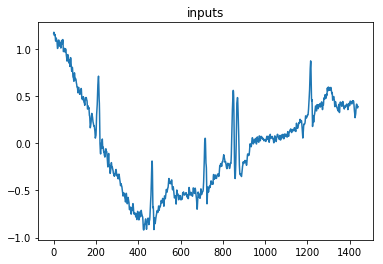

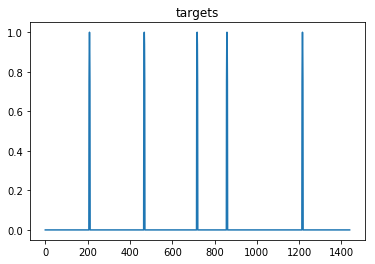

In [29]:
# let's visualize the model's input data and target data
iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
plt.plot(inp[0,:])
plt.title('inputs')
plt.show()
plt.plot(targ[0,:])
plt.title('targets')
plt.show()

In [30]:
ffwdModel = tf.keras.Sequential()
ffwdModel.add(layers.Dense(64, activation='relu',input_shape=(seqL*ninputs,)))
ffwdModel.add(layers.Dense(64, activation='relu'))
ffwdModel.add(layers.Dense(seqL*ninputs))

ffwdModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
ffwdModel.fit(trainData,  epochs=10, steps_per_epoch=1000, validation_data=valData, validation_steps=100)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0266 - mean_absolute_error: 0.0517 - val_loss: 0.0158 - val_mean_absolute_error: 0.0325
Epoch 2/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0162 - mean_absolute_error: 0.0330 - val_loss: 0.0156 - val_mean_absolute_error: 0.0322
Epoch 3/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0162 - mean_absolute_error: 0.0329 - val_loss: 0.0157 - val_mean_absolute_error: 0.0325
Epoch 4/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0162 - mean_absolute_error: 0.0330 - val_loss: 0.0157 - val_mean_absolute_error: 0.0322
Epoch 5/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0162 - mean_absolute_error: 0.0329 - val_loss: 0.0156 - val_mean_absolute_error: 0.0324
Epoch 6/10
1000/1000 [==============================] - 2s 2ms/step - loss

In [ ]:
# # number of examples
# N = ecgs_array.shape[2]

# # Sequence length (number of timesteps)
# seqL = 20

# # Sampling frequency
# fs = 360

# # For each timestep we give ninputs
# ninputs = int(0.2*fs)

# # We randomly select 35 files for the training set and the rest go to the validation set
# #training_file_indexes = random.sample(list(range(68)), 35)
# #validation_file_indexes = [x for x in range(68) if x not in training_file_indexes]
# training_file_indexes = [1, 2]
# validation_file_indexes = [3, 4]

# # training data
# # Create efficient training sequencess
# trainData =tf.data.Dataset.from_tensors(ecgs_array[training_file_indexes, :, :])
# trainData = trainData.map(lambda x:  selectFrom1ecg(x, seqL, ninputs, training_file_indexes))
# trainData = trainData.repeat()  # Repeat the input indefinitely.
# batchSize = 8
# trainData = trainData.batch(batchSize)

# valData = tf.data.Dataset.from_tensors(ecgs_array[validation_file_indexes, :, :])